# Branch & Bound and Knapsack Lab

**Objectives**
- Preform the branch and bound algorithm
- Apply branch and bound to the knapsack problem
- Understand the geometry of the branch and bound algorithm

**Brief description:** In this lab, we will try solving an example of a knapsack problem with the branch-and-bound algorithm. We will also see how adding a cutting plane helps in reducing the computation time and effort of the algorithm. Lastly, we will explore the geometry of the branch and bound algorithm.

In [1]:
# imports -- don't forget to run this cell
import pandas as pd
import gilp
from gilp.visualize import feasible_integer_pts
from ortools.linear_solver import pywraplp as OR

## Part 1: Branch and Bound Algorithm

Recall that the branch and bound algorithm (in addition to the simplex method) allows us to solve integer programs. Before applying the branch and bound algorithm to the knapsack problem, we will begin by reviewing some core ideas. Furthermore, we will identify a helpful property that will make branch and bound terminate quicker later in the lab!

**Q1:** What are the different ways a node can be fathomed during the branch and bound algorithm? Describe each.

**A:** One way a node can be fathomed is if the linear relaxation is infeasible, since an infeasible linear relaxation would also mean that the integer program is also infeasible at that node. Another way a node can be fathomed is if the linear relaxation has a non-integer optimal value greater than that of a known feasible solution to the integer program, since it is not possible for the integer program to have an optimal solution less than its linear relaxation. Therefore, it is not possible for the integer program at the node to have an optimal value that is better than that of the known feasible solution. A third way is if the objective function only contains integer coefficients, and the linear relaxation has a non-integer optimal value such that, when rounded up, is at least the optimal value of a known feasible solution to the integer program. Since the integer program at the node cannot have an optimal value that is better than the optimal value of a known feasible solution to the integer program, then there is no possibility in finding a better solution than the one already found. 

**Q2:** Suppose you have a maximization integer program and you solve its linear program relaxation. What does the LP-relaxation optimal value tell you about the IP optimal value? What if it is a minimization problem?

**A:** If it is a maximization problem, the linear relaxation's optimal value gives an upper bound for the IP optimal value. If it is a minimization problem, then the linear relxation's optimal value gives a lower bound for the IP optimal value.

**Q3:** Assume you have a maximization integer program with all integral coefficents in the objective function. Now, suppose you are running the branch and bound algorithm and come across a node with an optimal value of 44.5. The current incumbent is 44. Can you fathom this node? Why or why not?

**A:**  Yes, since the objective function value to the integer program must be an integer, and since the linear relaxation is an upper bound for the integer program, we know that the optimal value of the integer program at that node can be no better than 44. Therefore, we can fathom this node since we cannot find a better solution from its integer program.

**Q4:** If the optimal solution to the LP relaxation of the original program is integer, then you have found an optimal solution to your integer program. Explain why this is true.

**A:** Every feasible solution to the integer program is a feasible solution to the LP relaxation. Hence, the optimal value of the integer program must be at least the optimal value of the LP relaxation, assuming that this is a minimization problem. Furthermore, an integer LP relaxation solution is a feasible solution to the integer program. Hence, the optimal value of the integer LP relaxation must be at least the optimal value of the integer program. Since the optimal value of the integer LP relaxation is both at most and at least the optimal value of the integer program, they must be equal. For maximization problems, the same reasoning applies, as the LP relaxation can be shown to both be a lower and upper bound for the IP program.

**Q5:** If the LP is infeasible, then the IP is infeasible. Explain why this is true.

**A:** Every feasible solution to the IP is also a feasible solution to the LP. If there are no feasible solutions to the LP, there cannot be any feasible solutions to the IP.

The next questions ask about the following branch and bound tree. If the solution was not integral, the fractional $x_i$ that was used to branch is given. If the solution was integral, it is denoted *INT*. In the current iteration of branch and bound, you are looking at the node with the *****.

<img src="part1_bnb_tree.png" width="500"/>

**Q6:** Can you determine if the integer program this branch and bound tree is for is a minimization or maximixation problem? If so, which is it?

**A:** The integer program is a minimization problem, since the optimal value at each node is at least the optimal value of parent nodes.

Hint: For **Q7-8**, you can assume integral coefficents in the objective function.

**Q7:** Is the current node (marked $z^*$) fathomed? Why or why not? If not, what additional constraints should be imposed for each of the next two nodes?

**A:** No, the marked node is not fathomed, because the linear relaxation has an optimal value of $16.3$, which means that the optimal value must be at least $17$. Since we know a feasible solution to the integer program with an objective function value of $20$, we cannot rule out there is not an optimal solution to the integer program with a better optimal value at that node. We must therefore apply the constraints $x_1\geq1$ and $x_1\leq0$ to the next two nodes.

**Q8:** Consider the nodes under the current node (where $z = 16.3$). What do you know about the optimal value of these nodes? Why? 

**A:** Since this is a minimization problem, the linear program is a lower bound for the integer program at that node. Hence, the optimal value of the node must be at least $17$. Since every feasible solution to nodes below the current node is a feasible solution to the current node, all nodes underneath the current node must also have an optimal value of at least $17$.

## Part 2: The Knapsack Problem

In this lab, you will solve an integer program by branch and bound. The integer program to be solved will be a knapsack problem.

**Knapsack Problem:** We are given a collection of $n$ items, where each item $i = 1,\dots,n$ has a weight $w_i$ and a value $v_i$. In addition, there is a given capacity $W$, and the aim is to select a maximum value subset of items that has a total weight at most $W$. Note that each item can be brought at most once.

$$\begin{align*}
\max \quad & \sum_{i=1}^n v_ix_i\\
\text{s.t.} \quad & \sum_{i=1}^n w_ix_i \leq W \\
& 0 \leq x_i \leq 1, \text{integer}, i = 1,\dots,n
\end{align*}$$

Consider the following data which we import from a CSV file:

In [2]:
data = pd.read_csv('knapsack_data_1.csv', index_col=0)
data

value  weight
item               
1        50      10
2        30      12
3        24      10
4        14       7
5        12       6
6        10       7
7        40      30

and $W = 18$. 

**Q9:** Are there any items we can remove from our input to simplify this problem? Why? If so, replace `index` with the item number that can be removed in the code below. Hint: how many of each item could we possibly take?

**A:** Yes, we can remove item $7$, since we know that $W = 18$, so it would be impossible to carry an item with weight $30$.

In [4]:
# TODO: replace index
data = data.drop(7)

**Q10:** If we remove item 7 from the knapsack, it does not change the optimal solution to the integer program. Explain why.

**A:** There is no feasible solution that adds item $7$ to the knapsack, and hence, the feasible solutions to the problem are unchanged, so the feasible solution with the best objective function value is unchanged.

**Q11:** Consider removing items $i$ such that $w_i > W$ from a knapsack input. How does the LP relaxation's optimal value change?

**A:** The LP relaxation's optimal value in this case does change. This is because it might be possible to include fractional amounts of items $w_i$ in the linear program, so by removing the items, feasible solution of the LP relaxation also change. If one of the feasible solution is the optimal solution to the LP relaxation, then the optimal value could potentially increase.

In **Q10-11**, you should have found that removing these items removes feasible solutions from the linear program  but does not change the integer program. This is desirable as the gap between the optimal IP and LP values can become smaller. By adding this step, branch and bound may terminate sooner. 

Recall that a branch and bound node can be fathomed if its bound is no better than the value of the best feasible integer solution found thus far. Hence, it helps to have a good feasible integer solution as quickly as possible (so that we stop needless work). To do this, we can first try to construct a good feasible integer solution by a reasonable heuristic algorithm before starting to run the branch and bound procedure.

In designing a heuristic for the knapsack problem, it is helpful to think about the value per unit weight for each item. We compute this value in the table below.

In [5]:
data['value per unit weight'] = (data['value'] / data['weight']).round(2)
data

value  weight  value per unit weight
item                                      
1        50      10                   5.00
2        30      12                   2.50
3        24      10                   2.40
4        14       7                   2.00
5        12       6                   2.00
6        10       7                   1.43

**Q12:** Design a reasonable heuristic for the knapsack problem. Note a heuristic aims to find a decent solution to the problem (but is not necessarily optimal).

**A:** One heuristic would be to add the item with the next greatest value per unit weight that does not exceed the remaining weight of the knapsack. If there are multiple such items, then add the item with the smallest weight. If there is no such item that can be further added, then the algorithm is finished.

**Q13:** Run your heuristic on the data above to compute a good feasible integer solution. Your heuristic should generate a feasible solution with a value of 64 or better. If it does not, try a different heuristic (or talk to your TA!)

**A:** Item $1$ would be added first, since it has the greatest value per unit weight of $5$. The remaining weight is $8$, so the item with the next biggest value per unit weight is item $5$. Now the remainig weight is $1$, and since there are not items with weight $1$, we can stop here. The objective function value of this feasible solution is $50+14$ or $64$.

We will now use the branch and bound algorithm to solve this knapsack problem! First, let us define a mathematical model for the linear relaxation of the knapsack problem.

**Q14:** Complete the model below.

In [20]:
def Knapsack(table, capacity, integer = False):
    """Model for solving the Knapsack problem.
    
    Args:
        table (pd.DataFrame): A table indexd by items with a column for value and weight
        capacity (int): An integer-capacity for the knapsack
        integer (bool): True if the variables should be integer. False otherwise.
    """
    ITEMS = list(table.index)        # set of items
    v = table.to_dict()['value']     # value for each item 
    w = table.to_dict()['weight']    # weight for each item
    W = capacity                     # capacity of the knapsack
    
    # define model
    m = OR.Solver('knapsack', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # decision variables
    x = {}    
    for i in ITEMS:
        if integer:
            x[i] = m.IntVar(0, 1, 'x_%d' % (i)) 
        else:
            x[i] = m.NumVar(0, 1, 'x_%d' % (i)) 
        
    # define objective function here
    m.Maximize(sum(v[i]*x[i] for i in ITEMS))
    
    # TODO: Add a constraint that enforces that weight must not exceed capacity
    # recall that we add constraints to the model using m.Add()
    m.Add(sum(w[i]*x[i] for i in ITEMS) <= W)
        
    
    return (m, x)  # return the model and the decision variables

In [21]:
# You do not need to do anything with this cell but make sure you run it!
def solve(m):
    """Used to solve a model m."""
    m.Solve()
    
    print('Objective =', m.Objective().Value())
    print('iterations :', m.iterations())
    print('branch-and-bound nodes :',m.nodes())
    
    return ({var.name() : var.solution_value() for var in m.variables()})

We can now create a linear relaxation of our knapsack problem. Now, `m` represents our model and `x` represents our decision variables.

In [22]:
m, x = Knapsack(data, 18)

We can use the next line to solve the model and output the solution

In [23]:
solve(m)

Objective = 70.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.6666666666666667,
 'x_3': 0.0,
 'x_4': 0.0,
 'x_5': 0.0,
 'x_6': 0.0}

**Q15:** How does this optimal value compare to the value you found using the heuristic integer solution?

**A:** The optimal value of is $70$, which is greater than the value found using the heuristic integer solution.

**Q16:** Should this node be fathomed? If not, what variable should be branched on and what additional constraints should be imposed for each of the next two nodes?


**A:** No, the node should not be fathomed, since the LP relaxation is an upper bound to the IP. Since the optimal value to the LP relaxation is greater than that of the optimal value found through the heuristic integer solution, we cannot rule out the possibility that there is an optimal value greater than the value found through the heuristic. 

After constructing the linear relaxation model using `Knapsack(data1, 18)` we can add additional constraints. For example, we can add the constraint $x_2 \leq 0$ and solve it as follows:

In [24]:
m, x = Knapsack(data, 18)
m.Add(x[2] <= 0)
solve(m)

Objective = 69.2
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0, 'x_2': 0.0, 'x_3': 0.8, 'x_4': 0.0, 'x_5': 0.0, 'x_6': 0.0}

 **NOTE:** The line `m, x = Knapsack(data1, 18)` resets the model `m` to the LP relaxation. All constraints from branching have to be added each time.

**Q17:** Use the following cell to compute the optimal value for the other node you found in **Q16**.

In [25]:
m, x = Knapsack(data, 18)
m.Add(x[2] >= 1)
solve(m)

Objective = 60.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 0.6000000000000001,
 'x_2': 1.0,
 'x_3': 0.0,
 'x_4': 0.0,
 'x_5': 0.0,
 'x_6': 0.0}

**Q18:** What was the optimal value? Can this node be fathomed? Why? (Hint: In **Q13**, you found a feasible integer solution with value 64.)

**A:** The optimal value for the other node was $60$. Since there already exists a feasible integer solution with value $64$, and since the LP relaxation's optimal value is an upper bound for that of the IP, we know that the node cannot possibly have a greater optimal value than $60$, and so it cannot possibly have a better optimal value then that of the known feasible solution.

If we continue running the branch and bound algorithm, we will eventually reach the branch and bound tree below where the $z^*$ indictes the current node we are looking at.

<img src="part2_bnb_tree.png" width="700"/>

**Q19:** The node with $z = 64.857$ was fathomed. Why are we allowed to fathom this node? (Hint: think back to **Q3**)

**A:** The objective function has integer coefficients for all decision variables, and so the optimal value of the integer program must be an integer. Since we already know a feasible solution exists with an an optimal value equal to $64$, and since the LP relaxation's optimal value at that node must be at least the optimal value of the IP at that node, we can conclude that the node must have an optimal value of at most $64$, which cannot be better than the optimal value of the known feasible solution.

**Q20:** Finish running branch and bound to find the optimal integer solution. Use a separate cell for each node you solve and indicate if the node was fathomed with a comment. (Hint: Don't forget to include the constraints further up in the branch and bound tree.)

In [30]:
# Template
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[2]<=0)
m.Add(x[3]<=0)
m.Add(x[4]>=1)
m.Add(x[5]<=0)
solve(m)

Objective = 65.42857142857143
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 1.0,
 'x_5': 0.0,
 'x_6': 0.14285714285714302}

In [31]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[2]<=0)
m.Add(x[3]<=0)
m.Add(x[4]>=1)
m.Add(x[5]<=0)
m.Add(x[6]>=1)
solve(m)
#fathomed

Objective = 44.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 0.4, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 1.0, 'x_5': 0.0, 'x_6': 1.0}

In [32]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[2]<=0)
m.Add(x[3]<=0)
m.Add(x[4]>=1)
m.Add(x[5]<=0)
m.Add(x[6]<=0)
solve(m)

Objective = 64.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 1.0, 'x_5': 0.0, 'x_6': 0.0}

**A:** The optimal solution is $x_1 = x_4 = 1$ and $x_2 = x_3 = x_5 = x_6 = 0$.

**Q21:** How many nodes did you have to explore while running the branch and bound algorithm?

**A:** Exactly $11$ nodes.

In the next section, we will think about additional constraints we can add to make running branch and bound quicker.

## Part 3: Cutting Planes

In general, a cutting plane is an additional constraint we can add to an integer program's linear relaxation that removes feasible linear solutions but does not remove any integer feasible solutions. This is very useful when  solving integer programs! Recall many of the problems we have learned in class have something we call the "integrality property". This is useful because it allows us to ignore the integrality constraint since we are garunteed to reach an integral solution. By cleverly adding cutting planes, we strive to remove feasible linear solutions (without removing any integer feasible solutions) such that the optimal solution to the linear relaxation is integral!

Conisder an integer program whose linear program releaxation is 

$$\begin{align*}
\max \quad & 2x_1+x_2\\
\text{s.t.} \quad & x_1 + x_2 \leq 3 \\
& 2x_1 \leq 5 \\
& -x_1 + 2x_2 \leq 2 \\
& x_1, x_2 \geq 0
\end{align*}$$

We can define this linear program and then visualize its feasible region. The integer points have been highlighted.

In [29]:
lp = gilp.LP([[1,1],[2,0],[-1,2]],
             [3,5,2],
             [2,1])
fig = gilp.lp_visual(lp)
fig.set_axis_limits([3.5,2])
fig.add_trace(feasible_integer_pts(lp, fig))
fig

**Q22:** List every feasible solution to the integer program.

**A:** Feasible solutions are $(0,0)$, $(0,1)$, $(1,0)$, $(1,1)$, $(2,1)$, and $(2,0)$.

**Q23:** Is the constraint $x_2 \leq 1$ a cutting plane? Why? (Hint: Would any feasible integer points become infeasible? What about feasible linear points?)

**A:** Yes, since there the constraint does not remove any feasible integer solutions from the program, but it does remove feasible linear points.

Let's add this cutting plane to the LP relaxation!

In [33]:
lp = gilp.LP([[1,1],[2,0],[-1,2],[0,1]],
             [3,5,2,1],
             [2,1])
fig = gilp.lp_visual(lp)
fig.set_axis_limits([3.5,2])
fig.add_trace(feasible_integer_pts(lp, fig))
fig

**Q24:** Is the constraint $x_1 \leq 3$ a cutting plane? Why?

**A:** No, although it does not remove feasible integer points, it does not remove any feasible linear points either.

**Q25:** Can you provide another cutting plane? If so, what is it?

**A:** Another cutting plane is $x_1 \leq 2$.

Let's look at the feasible region after adding the cutting plane from **Q23** and one of the possible answers from **Q25**. Notice the optimal solution to the LP relaxation is now integral!

In [34]:
lp = gilp.LP([[1,1],[2,0],[-1,2],[0,1],[1,0]],
             [3,5,2,1,2],
             [2,1])
fig = gilp.lp_visual(lp)
fig.set_axis_limits([3.5,2])
fig.add_trace(feasible_integer_pts(lp, fig))
fig

Let's try applying what we know about cutting planes to the knapsack problem! Again, recall our input was $W = 18$ and:

In [35]:
data

value  weight  value per unit weight
item                                      
1        50      10                   5.00
2        30      12                   2.50
3        24      10                   2.40
4        14       7                   2.00
5        12       6                   2.00
6        10       7                   1.43

**Q26:** Look at items 1, 2, and 3. How many of these items can we take simultaneously? Can you write a new constraint to capture this? If so, please provide it.

**A:** We can only take $1$ of the $3$ items, so $x_1 + x_2 + x_3 \leq 1$.

**Q27:** Is the constraint you found in **Q26** a cutting plane? If so, provide a feasible solution to the linear program relaxation that is no longer feasible (i.e. a point the constraint *cuts off*).

**A:** Yes, since it does not remove any feasible integer solutions, but it does remove feasible linear solutions. One example of a linear solution that is no longer feasible is $x_2 = 1.5, x_1 = x_3 = x_4 = x_5 = x_6 = 0$.

**Q28:** Provide another cutting plane involving items 4,5 and 6 for this integer program. Explain how you derived it.

**A:** $x_4+x_5+x_6\leq2$ Since only $2$ items among items $4$,$5$,and $6$ can be added.

**Q29:** Add the cutting planes from **Q26** and **Q28** to the model and solve it. You should get a solution in which we take items 1 and 4 and $\frac{1}{6}$ of item 5 with an objective value of 66.

In [36]:
m, x = Knapsack(data, 18)
# TODO: Add cutting planes here
m.Add(x[1]+x[2]+x[3]<=1)
m.Add(x[4]+x[5]+x[6]<=2)
solve(m)

Objective = 66.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 1.0,
 'x_5': 0.16666666666666696,
 'x_6': 0.0}

Let's take a moment to pause and reflect on what we are doing. Recall from **Q9-11** that we dropped item 7 becuase its weight was greater than the capcity of the knapsack. Essentially we added the constraint $x_7 \leq 0$. This constraint was a cutting plane! It eliminated some linear feasible solutions but no integer ones. By adding these two new cutting planes, we can get branch and bound to terminate earlier yet again! So far, we have generated cutting planes by inspection. However, there are more algorithmic ways to identify them (which we will ignore for now).

If we continue running the branch and bound algorithm, we will eventually reach the branch and bound tree below where the $z^*$ indictes the current node we are looking at. 

<img src="part3_bnb_tree.png" width="700"/>

**NOTE:** Do not forget about the feasible integer solution our heuristic gave us with value 64.

**Q30** Finish running branch and bound to find the optimal integer solution. Use a separate cell for each node you solve and indicate if the node was fathomed with a comment. Hint: Don't forget the cutting plane constraints should be included in every node of the branch and bound tree.

In [41]:
# Template
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[1]+x[2]+x[3]<=1)
m.Add(x[4]+x[5]+x[6]<=2)
m.Add(x[5]>=1)
solve(m)

Objective = 66.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 0.28571428571428586,
 'x_5': 1.0,
 'x_6': 0.0}

In [42]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[1]+x[2]+x[3]<=1)
m.Add(x[4]+x[5]+x[6]<=2)
m.Add(x[5]>=1)
m.Add(x[4]<=0)
solve(m)
# fathomed

Objective = 64.85714285714286
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 0.0,
 'x_5': 1.0,
 'x_6': 0.28571428571428586}

In [43]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[1]+x[2]+x[3]<=1)
m.Add(x[4]+x[5]+x[6]<=2)
m.Add(x[5]>=1)
m.Add(x[4]<=0)
m.Add(x[6]<=0)
solve(m)
# fathomed

Objective = 62.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 0.0, 'x_5': 1.0, 'x_6': 0.0}

In [45]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add(x[1]+x[2]+x[3]<=1)
m.Add(x[4]+x[5]+x[6]<=2)
m.Add(x[5]>=1)
m.Add(x[4]<=0)
m.Add(x[6]>=1)
solve(m)
# fathomed

Objective = 47.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 0.5, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 0.0, 'x_5': 1.0, 'x_6': 1.0}

**A:** The optimal solution is $x_1=x_4=1$, $x_2=x_3=x_5=x_6=0$.

**Q31:** Did you find the same optimal solution? How many nodes did you explore? How did this compare to the number you explored previously?

**A:** Yes, I found the same optimal solution, but this time by exploring only $8$ nodes as opposed to the previous number of $11$ nodes.

## Part 4: Geometry of Branch and Bound

Previously, we used the `gilp` package to viusualize the simplex algorithm but it also has the functionality to visualize branch and bound. We will give a quick overview of the tool. Similar to `lp_visual` and `simplex_visual`, the function `bnb_visual` takes an `LP` and returns a visualization. It is assumed that every decision variable is constrained to be integer. Unlike previous visualizations, `bnb_visual` returns a series of figures for each node of the branch and bound tree. Let's look at a small 2D example:

$$\begin{align*}
\max \quad & 5x_1+ 8x_2\\
\text{s.t.} \quad & x_1 + x_2 \leq 6 \\
& 5x_1 + 9x_2 \leq 45 \\
& x_1, x_2 \geq 0, \quad \text{integral}
\end{align*}$$

In [46]:
nodes = gilp.bnb_visual(gilp.examples.STANDARD_2D_IP)

In [47]:
nodes[0].show()

Run the cells above to generate a figure for each node and view the first node. At first, you will see the LP relaxation on the left and the root of the branch and bound tree on the right. The simplex path and isoprofit slider are also present.

**Q32:** Recall the root of a branch and bound tree is the unaltered LP relaxation. What is the optimal solution? (Hint: Use the objective slider and hover over extreme points).

**A:** The optimal solution is $(2.25,3.75)$, where the optimal values is $41.25$.

**Q33:** Assume that we always choose the variable with the minimum index to branch on if there are multiple options. Write down (in full) each of the LPs we get after branching off the root node.

**A:** $$\begin{align*}
\max \quad & 5x_1+ 8x_2\\
\text{s.t.} \quad & x_1 + x_2 \leq 6 \\
& 5x_1 + 9x_2 \leq 45 \\
& x_1 \leq 2\\
& x_1, x_2 \geq 0, \quad \text{integral}
\end{align*}$$
$$\begin{align*}
\max \quad & 5x_1+ 8x_2\\
\text{s.t.} \quad & x_1 + x_2 \leq 6 \\
& 5x_1 + 9x_2 \leq 45 \\
& x_1 \geq 3\\
& x_1, x_2 \geq 0, \quad \text{integral}
\end{align*}$$

**Q34:** Draw the feasible region to each of the LPs from **Q33** on the same picture.

**A:** 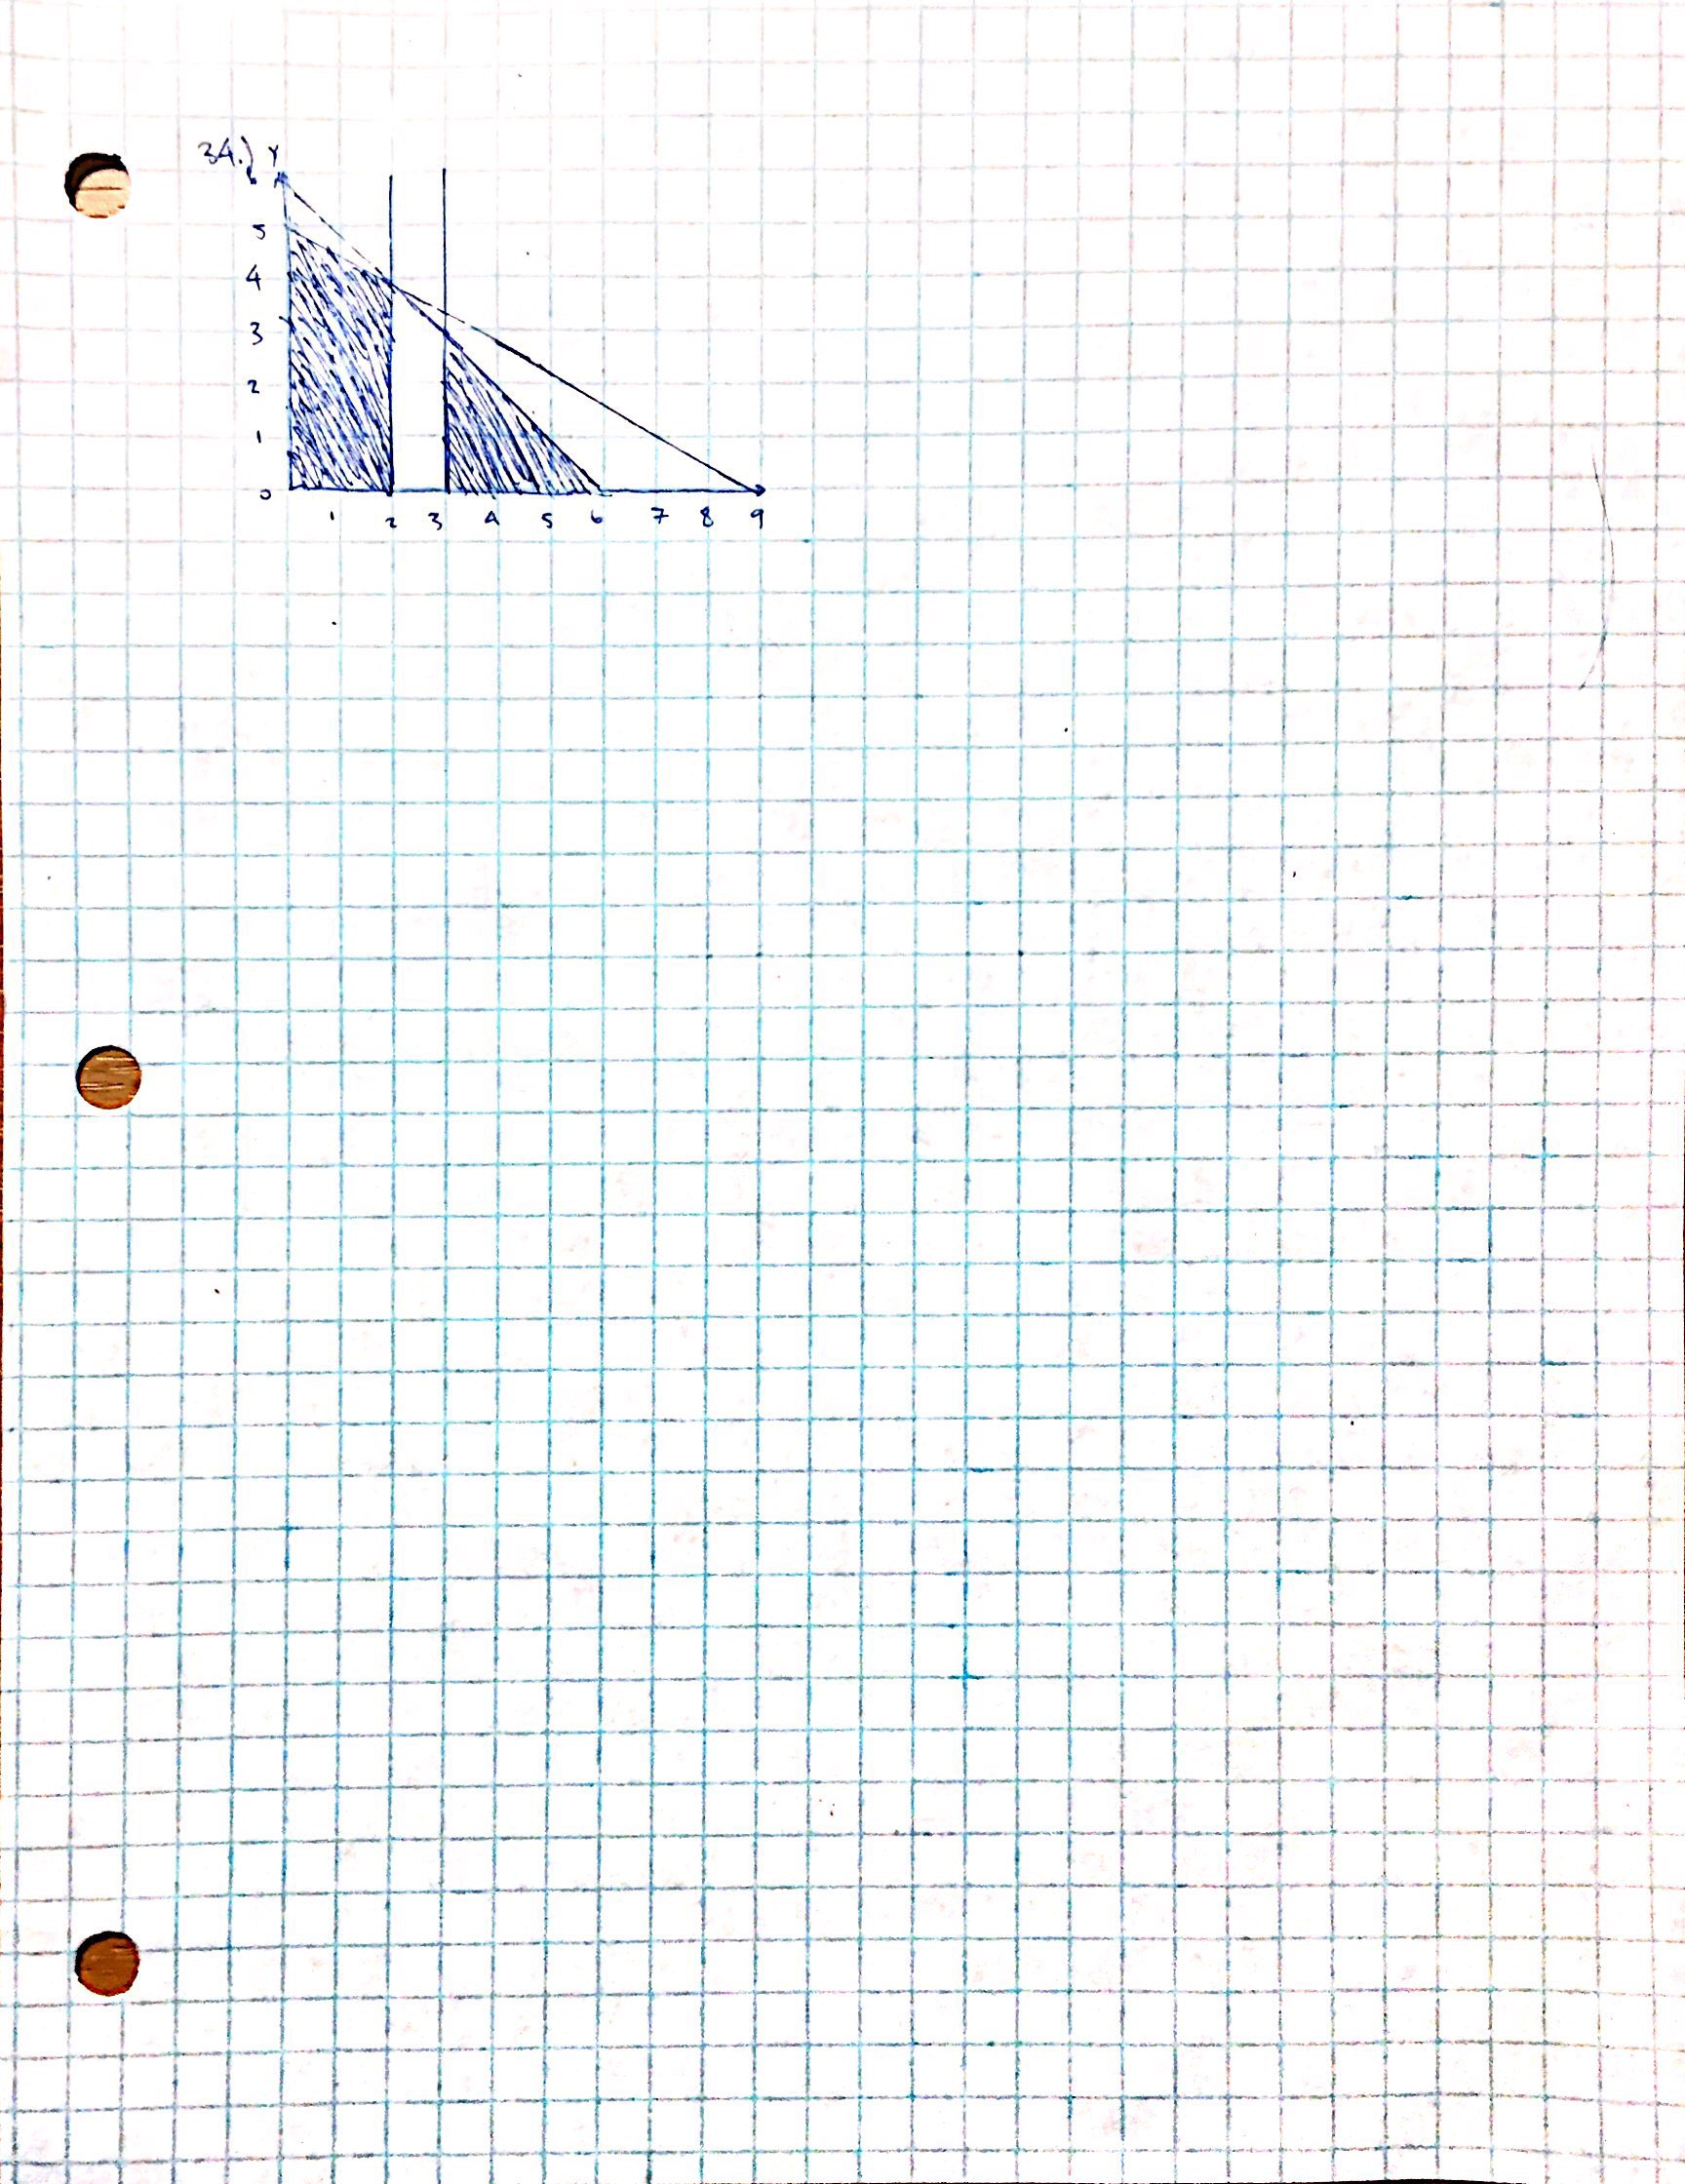

Run the following cell to see if the picture you drew in **Q34** was correct.

In [48]:
nodes[1].show()

The outline of the original LP relaxation is still shown on the left. Now that we have eliminated some of the fractional feasible solutions, we now have 2 feasible regions to consider. The darker one is the feasible region associated with the current node which is also shaded darker in the branch and bound tree. The unexplored nodes in the branch and bound tree are not shaded in.

**Q35:** Which feasible solutions to the LP relaxation are removed by this branch?

**A:** All solutions to the right of $x_1\geq2$ and $x_1\leq3$ are removed by the current branch.

**Q36:** At the current (dark) node, what constraints will we add? How many feasible regions will the original LP relaxation be broken into?

**A:** We should add constraints $x_2\geq4$ and $x_2\leq 3$.

In [49]:
nodes[2].show()

**Q37:** What is the optimal solution at the current (dark) node? Do we have to further explore this branch? Explain.

**A:** The optimal solution at the current node is $(2,3)$, which has an optimal value of $34$. Since the linear program relaxation has an integer solution we can conclude that it must be the optimal solution for the integer program at that node. Hence, there is no need to continue to branch from this node.

**Q38:** Recall shaded nodes have been explored and the node shaded darker (and feasible region shaded darker) correspond to the current node and its feasible region. Nodes not shaded have not been explored. How many nodes have not yet been explored?

**A:** 2 nodes have not been explored, as there are two feasible regions that are not shaded in.

**Q39:** How many nodes have a degree of one in the branch and bound tree? (That is, they are only connected to one edge). These nodes are called leaf nodes. What is the relationship between the leaf nodes and the remaining feasible region?

**A:** There are 2 leaf nodes. The number of leaf nodes should equal the number of remaining feasible regions that have not yet been solved.

In [50]:
# Show the next two iterations of the branch and bound algorithm
nodes[3].show()
nodes[4].show()

**Q40:** At the current (dark) node, we added the constraint $x_1 \leq 1$. Why were the fractional solutions $1 < x_1 < 2$ not eliminated for $x_2 \leq 3$?

**A:** The node adding constraint $x_2 \leq 3$ had an integer linear program optimal solution. Therefore, there as no need to continue to branch out from that node.

In [51]:
# Show the next three iterations of the branch and bound algorithm
nodes[5].show()
nodes[6].show()
nodes[7].show()

**Q41:** What constraints are enforced at the current (dark) node? Why are there no feasible solutions at this node?

**A:** Constraints $x_1\leq2$, $x_2\geq4$, and $x_1\geq2$ are enforced. However, since there are no points in the feasible region that satisfy $x_1 = 2$ and $x_4\geq4$ there are no feasible solutions at this node.

In [52]:
nodes[8].show()

**Q42:** Are we done? If so, what nodes are fathomed and what is the optimal solution? Explain.

**A:** Nodes $x_1\geq2$, $x_2\leq3$, $x_2\leq4$, $x_2\geq3$ are fathomed.
The optimal solution $(0,5)$, whereas the optimal value is $40$.

Let's look at branch and bound visualization for an integer program with 3 decision variables!

In [53]:
nodes = gilp.bnb_visual(gilp.examples.VARIED_BRANCHING_3D_IP)

In [54]:
# Look at the first 3 iterations
nodes[0].show()
nodes[1].show()
nodes[2].show()

Let's fast-forward to the final iteration of the branch and bound algorithm.

In [55]:
nodes[-1].show()

**Q43:** Consider the feasible region that looks like a rectangular box with one corner point at the origin. What node does it correspond to in the tree? What is the optimal solution at that node?

**A:** It corresponds to the node $x_3\leq 2$. The optimal solution at that nodes is $(1,2,2)$, which has an optimal value of $12$.

**Q44:** How many branch and bound nodes did we explore? What was the optimal solution? How many branch and bound nodes would we have explored if we knew the value of the optimal solution before starting branch and bound?

**A:** We explore $13$ nodes. The optimal solution is $(0,3,1)$, with an optimal value of $13$. If we knew this value before starting branch and bound, we would have only explored $2$ nodes, since we would not further explore the branch from node $x_2\leq2$.

## Bonus: Branch and Bound for Knapsack

Consider the following example:

| item | value | weight
|------|-------|-------
|  1   |   2   |   1 
|  2   |   9   |   3 
|  3   |   6   |   2 

The linear program formulation will be:


$$\begin{align*}
\max \quad & 2x_1+9x_2+6x_3\\
\text{s.t.} \quad & 1x_1+3x_2+2x_3 \leq 10 \\
& x_1, x_2, x_3 \geq 0, \quad \text{integer}
\end{align*}$$

In gilp, we can define this lp as follows:

In [56]:
lp = gilp.LP([[1,3,2]],
             [10],
             [2,9,6])

for fig in gilp.bnb_visual(lp):
    fig.show()